In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.47MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 151kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.80MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.24MB/s]


In [ ]:
print("Total training samples:", len(train_dataset))
print("Total test samples:", len(test_dataset))

image, label = train_dataset[0]
print("Single image shape:", image.shape)
print("Label:", label)


Total training samples: 60000
Total test samples: 10000
Single image shape: torch.Size([1, 28, 28])
Label: 9


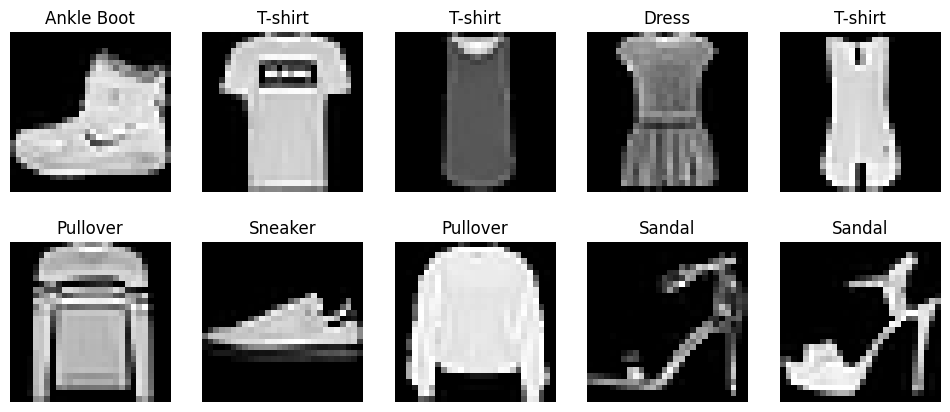

In [ ]:
labels_map = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(labels_map[label])
    ax.axis("off")

plt.show()


In [ ]:
NORMAL_CLASS = 7

normal_indices = [
    i for i, (_, label) in enumerate(train_dataset)
    if label == NORMAL_CLASS
]

normal_train_dataset = Subset(train_dataset, normal_indices)

train_loader = DataLoader(
    normal_train_dataset,
    batch_size=128,
    shuffle=True
)

print("Normal training samples:", len(normal_train_dataset))


Normal training samples: 6000


In [ ]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat


In [ ]:
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        recon = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/10] Loss: 0.0636
Epoch [2/10] Loss: 0.0137
Epoch [3/10] Loss: 0.0093
Epoch [4/10] Loss: 0.0057
Epoch [5/10] Loss: 0.0040
Epoch [6/10] Loss: 0.0031
Epoch [7/10] Loss: 0.0025
Epoch [8/10] Loss: 0.0022
Epoch [9/10] Loss: 0.0019
Epoch [10/10] Loss: 0.0017


In [ ]:
model.eval()

def show_reconstructions(dataset, title, n=5):
    fig, axes = plt.subplots(2, n, figsize=(12, 4))

    for i in range(n):
        img, _ = dataset[i]
        img = img.unsqueeze(0).to(device)

        with torch.no_grad():
            recon = model(img)

        axes[0, i].imshow(img.cpu().squeeze(), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        axes[1, i].imshow(recon.cpu().squeeze(), cmap="gray")
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    fig.suptitle(title)
    plt.show()


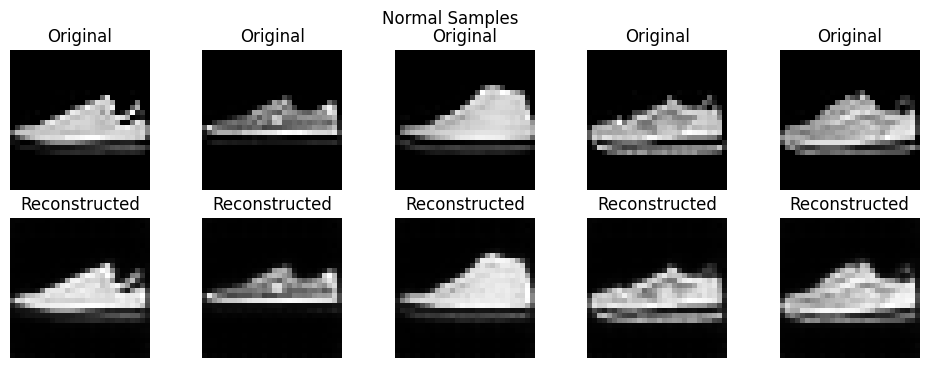

In [ ]:
show_reconstructions(normal_train_dataset, "Normal Samples")


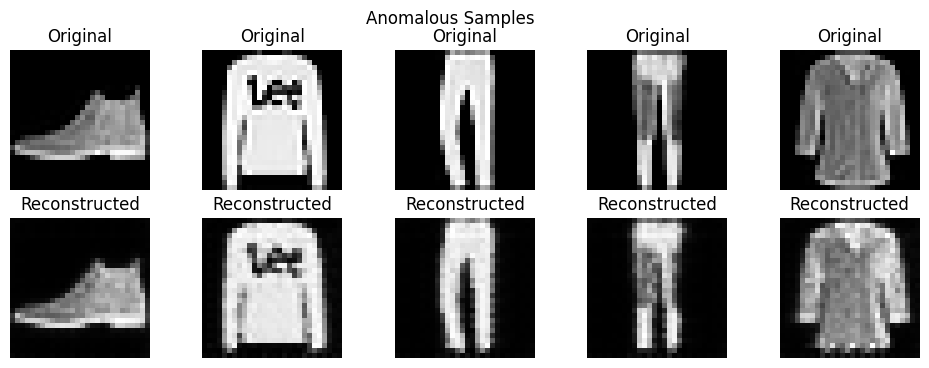

In [ ]:
anomaly_indices = [
    i for i, (_, label) in enumerate(test_dataset)
    if label != NORMAL_CLASS
]

anomaly_dataset = Subset(test_dataset, anomaly_indices)

show_reconstructions(anomaly_dataset, "Anomalous Samples")


In [ ]:
def reconstruction_error(model, dataset):

    errors = []

    with torch.no_grad():
        for img, _ in dataset:
            img = img.unsqueeze(0).to(device)
            recon = model(img)
            error = torch.mean((img - recon) ** 2).item()
            errors.append(error)

    return np.array(errors)


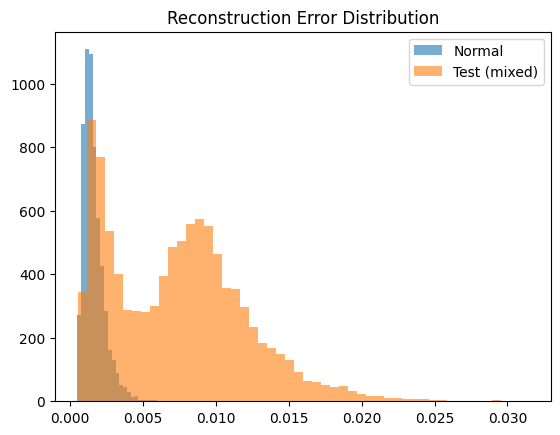

In [ ]:
normal_errors = reconstruction_error(model, normal_train_dataset)
test_errors = reconstruction_error(model, test_dataset)

plt.hist(normal_errors, bins=50, alpha=0.6, label="Normal")
plt.hist(test_errors, bins=50, alpha=0.6, label="Test (mixed)")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()


In [ ]:
mean_error = normal_errors.mean()
std_error = normal_errors.std()

threshold = mean_error + 3 * std_error

print("Anomaly Threshold:", threshold)


Anomaly Threshold: 0.004001994049240463


In [ ]:
y_true = []
y_pred = []

for i, (img, label) in enumerate(test_dataset):
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        recon = model(img)
        error = torch.mean((img - recon) ** 2).item()

    y_true.append(0 if label == NORMAL_CLASS else 1)
    y_pred.append(1 if error > threshold else 0)


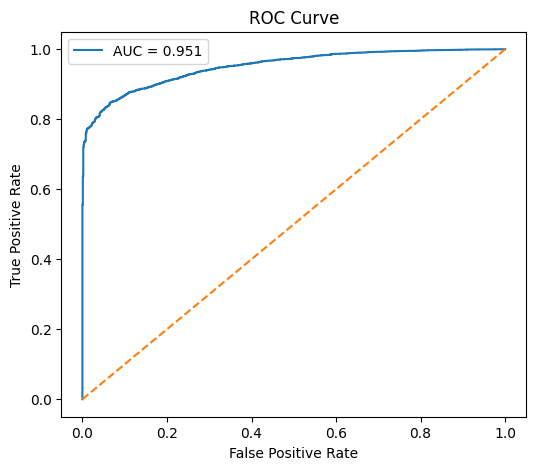

In [ ]:
from sklearn.metrics import roc_curve, auc

scores = []

for img, _ in test_dataset:
    img = img.unsqueeze(0).to(device)
    with torch.no_grad():
        recon = model(img)
        error = torch.mean((img - recon) ** 2).item()
    scores.append(error)

fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
